# UFC Fighter Analysis Notebook

This notebook analyzes UFC fighter data to create fighter profiles, identify diverse fighting styles through clustering, and simulate fan preferences using the OCEAN personality framework.

## Objectives
- Feature-engineer per-fighter statistics (strikes, takedowns, control time)
- Create 8-12 distinct fighter clusters representing diverse fighting styles
- Simulate fan preferences using OCEAN personality traits
- Explain why different personality types prefer different fighting styles


In [37]:
# Install required packages
%pip install pandas numpy scikit-learn umap-learn matplotlib seaborn plotly hdbscan


Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set random seed for reproducibility
np.random.seed(42)


## 1. Setup and Data Loading


In [39]:
# Load UFC data from the cloned repository
import subprocess

ufc_repo_dir = Path('UFC-DataLab')
repo_url = 'https://github.com/komaksym/UFC-DataLab.git'

if not ufc_repo_dir.exists():
    print("⚠️ UFC-DataLab repository not found!")
    print(f"Cloning repository: {repo_url}")
    print("This may take a few moments...")
    
    try:
        result = subprocess.run(
            ['git', 'clone', repo_url],
            capture_output=True,
            text=True,
            check=True
        )
        print(f"✓ Repository cloned successfully to {ufc_repo_dir}/")
    except subprocess.CalledProcessError as e:
        print(f"⚠️ Error cloning repository: {e.stderr}")
        print("\nMake sure git is installed. You can also:")
        print(f"1. Manually clone: git clone {repo_url}")
        print(f"2. Or download as ZIP from: {repo_url}")
        ufc_data = None
    except FileNotFoundError:
        print("⚠️ Git is not installed. Please install git or clone manually:")
        print(f"git clone {repo_url}")
        ufc_data = None

if ufc_repo_dir.exists():
    print(f"✓ Found repository at: {ufc_repo_dir.absolute()}")
    
    # Look for data files
    data_paths = {
        'merged': ufc_repo_dir / 'data' / 'merged_stats_n_scorecards',
        'stats': ufc_repo_dir / 'data' / 'stats',
        'scorecards': ufc_repo_dir / 'data' / 'scorecards'
    }
    
    # Try to find CSV files
    all_csv_files = []
    for name, path in data_paths.items():
        if path.exists():
            csv_files = list(path.glob('*.csv'))
            if csv_files:
                print(f"✓ Found {len(csv_files)} CSV files in {name}/")
                all_csv_files.extend(csv_files)
    
    if all_csv_files:
        print(f"\nTotal CSV files found: {len(all_csv_files)}")
        
        # Prefer merged_stats_n_scorecards.csv (most comprehensive)
        merged_file = ufc_repo_dir / 'data' / 'merged_stats_n_scorecards' / 'merged_stats_n_scorecards.csv'
        if merged_file.exists():
            main_file = merged_file
            print(f"\nUsing merged dataset: {main_file.name}")
        else:
            # Use the largest file as fallback
            main_file = max(all_csv_files, key=lambda f: f.stat().st_size)
            print(f"\nLoading main dataset: {main_file.name}")
        
        print(f"File size: {main_file.stat().st_size / 1024 / 1024:.2f} MB")
        
        try:
            ufc_data = pd.read_csv(main_file)
            print(f"✓ Loaded successfully!")
            print(f"Shape: {ufc_data.shape[0]:,} rows x {ufc_data.shape[1]} columns")
            print(f"\nSample columns:")
            print([col for col in ufc_data.columns if any(x in col.lower() for x in ['fighter', 'strike', 'td', 'ctrl', 'date'])][:15])
        except Exception as e:
            print(f"⚠️ Error loading file: {e}")
            ufc_data = None
    else:
        print("⚠️ No CSV files found in repository")
        print("\nChecking repository structure...")
        # List what's actually in the repo
        if ufc_repo_dir.exists():
            for item in ufc_repo_dir.iterdir():
                if item.is_dir():
                    print(f"   Directory: {item.name}")
        ufc_data = None


✓ Found repository at: /Users/andyreischling/Documents/GitHub/Paramount-streaming/UFC-DataLab
✓ Found 1 CSV files in merged/
✓ Found 2 CSV files in stats/

Total CSV files found: 3

Using merged dataset: merged_stats_n_scorecards.csv
File size: 3.36 MB
✓ Loaded successfully!
Shape: 7,756 rows x 61 columns

Sample columns:
['red_fighter_name', 'blue_fighter_name', 'event_date', 'red_fighter_nickname', 'blue_fighter_nickname', 'red_fighter_result', 'blue_fighter_result', 'red_fighter_KD', 'blue_fighter_KD', 'red_fighter_sig_str', 'blue_fighter_sig_str', 'red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct', 'red_fighter_total_str', 'blue_fighter_total_str']


In [40]:
# Explore the data structure
if ufc_data is not None:
    print("Dataset Info:")
    print("=" * 80)
    print(f"Total rows: {len(ufc_data):,}")
    print(f"Total columns: {len(ufc_data.columns)}")
    print(f"\nFirst few rows:")
    display(ufc_data.head())
    
    print(f"\nData types:")
    print(ufc_data.dtypes.value_counts())
    
    print(f"\nMissing values:")
    missing = ufc_data.isnull().sum()
    missing_pct = (missing / len(ufc_data) * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing %': missing_pct
    }).sort_values('Missing Count', ascending=False)
    display(missing_df[missing_df['Missing Count'] > 0].head(20))
    
    # Check for fighter-related columns
    print(f"\nFighter-related columns:")
    fighter_cols = [col for col in ufc_data.columns if any(term in col.lower() for term in ['fighter', 'fighter_', 'name', 'strikes', 'takedown', 'control', 'clinch'])]
    print(fighter_cols)
else:
    print("⚠️ No data loaded. Please check the previous cell.")


Dataset Info:
Total rows: 7,756
Total columns: 61

First few rows:


,red_fighter_name,blue_fighter_name,event_date,red_fighter_nickname,blue_fighter_nickname,red_fighter_result,blue_fighter_result,method,round,time,...,red_fighter_sig_str_leg_pct,blue_fighter_sig_str_leg_pct,red_fighter_sig_str_distance_pct,blue_fighter_sig_str_distance_pct,red_fighter_sig_str_clinch_pct,blue_fighter_sig_str_clinch_pct,red_fighter_sig_str_ground_pct,blue_fighter_sig_str_ground_pct,red_fighter_total_pts,blue_fighter_total_pts
0,ILIA TOPURIA,MAX HOLLOWAY,26/10/2024,El Matador,Blessed,W,L,KO/TKO,3,1:34,...,20,24,94,100,0,0,5,0,20 20 19,18 18 19
1,ROBERT WHITTAKER,KHAMZAT CHIMAEV,26/10/2024,The Reaper,Borz,L,W,Submission,1,3:34,...,100,0,100,0,0,0,0,100,- - -,- - -
2,MAGOMED ANKALAEV,ALEKSANDAR RAKIC,26/10/2024,-,Rocket,W,L,Decision - Unanimous,3,5:00,...,23,64,90,94,9,5,0,0,29 29 29,28 28 28
3,LERONE MURPHY,DAN IGE,26/10/2024,The Miracle,50K,W,L,Decision - Unanimous,3,5:00,...,7,13,71,69,23,13,5,17,29 29 29,28 28 28
4,SHARA MAGOMEDOV,ARMEN PETROSYAN,26/10/2024,Bullet,Superman,W,L,KO/TKO,2,4:52,...,18,58,96,97,3,2,0,0,10 10 10,9 9 9



Data types:
object    60
int64      1
Name: count, dtype: int64

Missing values:


,Missing Count,Missing %
blue_fighter_total_pts,5624,72.51
red_fighter_total_pts,5624,72.51



Fighter-related columns:
['red_fighter_name', 'blue_fighter_name', 'red_fighter_nickname', 'blue_fighter_nickname', 'red_fighter_result', 'blue_fighter_result', 'event_name', 'red_fighter_KD', 'blue_fighter_KD', 'red_fighter_sig_str', 'blue_fighter_sig_str', 'red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct', 'red_fighter_total_str', 'blue_fighter_total_str', 'red_fighter_TD', 'blue_fighter_TD', 'red_fighter_TD_pct', 'blue_fighter_TD_pct', 'red_fighter_sub_att', 'blue_fighter_sub_att', 'red_fighter_rev', 'blue_fighter_rev', 'red_fighter_ctrl', 'blue_fighter_ctrl', 'red_fighter_sig_str_head', 'blue_fighter_sig_str_head', 'red_fighter_sig_str_body', 'blue_fighter_sig_str_body', 'red_fighter_sig_str_leg', 'blue_fighter_sig_str_leg', 'red_fighter_sig_str_distance', 'blue_fighter_sig_str_distance', 'red_fighter_sig_str_clinch', 'blue_fighter_sig_str_clinch', 'red_fighter_sig_str_ground', 'blue_fighter_sig_str_ground', 'red_fighter_sig_str_head_pct', 'blue_fighter_sig_str_head_pct', 'red

## 2. Feature Engineering - Per-Fighter Stats

### 2.1 Strike Statistics


In [41]:
# Parse the actual UFC-DataLab data format
# The data has red_fighter_* and blue_fighter_* columns
# We need to reshape to have one row per fighter per fight

def reshape_ufc_data(df):
    """
    Reshape UFC data from red/blue format to long format (one row per fighter per fight).
    """
    # Identify red and blue fighter columns
    red_cols = [col for col in df.columns if col.startswith('red_fighter_')]
    blue_cols = [col for col in df.columns if col.startswith('blue_fighter_')]
    
    # Common columns (not fighter-specific)
    common_cols = [col for col in df.columns if col not in red_cols + blue_cols]
    
    # Create red fighter dataframe
    red_df = df[common_cols + red_cols].copy()
    red_df.columns = common_cols + [col.replace('red_fighter_', '') for col in red_cols]
    red_df['fighter_color'] = 'red'
    red_df['opponent_color'] = 'blue'
    
    # Create blue fighter dataframe
    blue_df = df[common_cols + blue_cols].copy()
    blue_df.columns = common_cols + [col.replace('blue_fighter_', '') for col in blue_cols]
    blue_df['fighter_color'] = 'blue'
    blue_df['opponent_color'] = 'red'
    
    # Combine
    long_df = pd.concat([red_df, blue_df], ignore_index=True)
    
    return long_df

if ufc_data is not None:
    print("Reshaping data from red/blue format to long format...")
    ufc_long = reshape_ufc_data(ufc_data)
    print(f"✓ Reshaped: {len(ufc_data)} fights -> {len(ufc_long)} fighter-fight records")
    print(f"\nSample columns after reshaping:")
    print([col for col in ufc_long.columns if any(x in col.lower() for x in ['name', 'strike', 'td', 'ctrl', 'time'])][:15])
    display(ufc_long[['name', 'result', 'sig_str', 'total_str', 'TD', 'ctrl', 'time']].head())
else:
    print("⚠️ No data available")


Reshaping data from red/blue format to long format...
✓ Reshaped: 7756 fights -> 15512 fighter-fight records

Sample columns after reshaping:
['time', 'time_format', 'event_name', 'name', 'nickname', 'TD', 'TD_pct', 'ctrl']


,name,result,sig_str,total_str,TD,ctrl,time
0,ILIA TOPURIA,W,75 of 144,78 of 147,2 of 2,0:45,1:34
1,ROBERT WHITTAKER,L,2 of 2,2 of 2,0 of 0,0:00,3:34
2,MAGOMED ANKALAEV,W,55 of 114,75 of 142,0 of 0,1:31,5:00
3,LERONE MURPHY,W,52 of 100,78 of 133,3 of 5,2:17,5:00
4,SHARA MAGOMEDOV,W,65 of 106,67 of 108,0 of 0,0:02,4:52


In [42]:
# Engineer features based on actual UFC-DataLab format
def parse_time_to_seconds(time_str):
    """Parse time string like '1:34' or '15:00' to total seconds"""
    if pd.isna(time_str) or time_str == '':
        return np.nan
    try:
        parts = str(time_str).split(':')
        if len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
        elif len(parts) == 1:
            return int(parts[0])
        else:
            return np.nan
    except:
        return np.nan

def parse_fraction(fraction_str):
    """Parse fraction string like '75 of 144' to (landed, attempted)"""
    if pd.isna(fraction_str) or fraction_str == '':
        return np.nan, np.nan
    try:
        parts = str(fraction_str).split(' of ')
        if len(parts) == 2:
            return int(parts[0]), int(parts[1])
        else:
            return np.nan, np.nan
    except:
        return np.nan, np.nan

def engineer_fighter_features(df):
    """
    Engineer comprehensive fighter features from UFC-DataLab format.
    """
    df = df.copy()
    features_df = pd.DataFrame()
    
    # Fighter name
    features_df['fighter'] = df['name']
    
    # Parse fight time
    fight_time_seconds = df['time'].apply(parse_time_to_seconds)
    fight_time_minutes = fight_time_seconds / 60
    
    # Parse significant strikes (format: "75 of 144")
    sig_str_landed, sig_str_attempted = zip(*df['sig_str'].apply(parse_fraction))
    sig_str_landed = pd.Series(sig_str_landed)
    sig_str_attempted = pd.Series(sig_str_attempted)
    
    # Parse total strikes
    total_str_landed, total_str_attempted = zip(*df['total_str'].apply(parse_fraction))
    total_str_landed = pd.Series(total_str_landed)
    total_str_attempted = pd.Series(total_str_attempted)
    
    # Strikes per minute
    features_df['strikes_landed_per_min'] = sig_str_landed / fight_time_minutes.replace(0, np.nan)
    features_df['strikes_attempted_per_min'] = sig_str_attempted / fight_time_minutes.replace(0, np.nan)
    
    # Strike accuracy (use percentage if available, otherwise calculate)
    if 'sig_str_pct' in df.columns:
        features_df['strike_accuracy'] = pd.to_numeric(df['sig_str_pct'], errors='coerce') / 100
    else:
        features_df['strike_accuracy'] = sig_str_landed / sig_str_attempted.replace(0, np.nan)
    
    # Parse head/body/leg strikes
    head_landed, head_attempted = zip(*df['sig_str_head'].apply(parse_fraction))
    body_landed, body_attempted = zip(*df['sig_str_body'].apply(parse_fraction))
    leg_landed, leg_attempted = zip(*df['sig_str_leg'].apply(parse_fraction))
    
    head_landed = pd.Series(head_landed)
    body_landed = pd.Series(body_landed)
    leg_landed = pd.Series(leg_landed)
    
    # Calculate strike ratios (proportion of significant strikes)
    total_sig = head_landed.fillna(0) + body_landed.fillna(0) + leg_landed.fillna(0)
    features_df['head_strike_ratio'] = head_landed / total_sig.replace(0, np.nan)
    features_df['body_strike_ratio'] = body_landed / total_sig.replace(0, np.nan)
    features_df['leg_strike_ratio'] = leg_landed / total_sig.replace(0, np.nan)
    
    # Use percentage columns if available (more accurate)
    if 'sig_str_head_pct' in df.columns:
        features_df['head_strike_ratio'] = pd.to_numeric(df['sig_str_head_pct'], errors='coerce') / 100
    if 'sig_str_body_pct' in df.columns:
        features_df['body_strike_ratio'] = pd.to_numeric(df['sig_str_body_pct'], errors='coerce') / 100
    if 'sig_str_leg_pct' in df.columns:
        features_df['leg_strike_ratio'] = pd.to_numeric(df['sig_str_leg_pct'], errors='coerce') / 100
    
    # Parse takedowns (format: "2 of 2")
    td_landed, td_attempted = zip(*df['TD'].apply(parse_fraction))
    td_landed = pd.Series(td_landed)
    td_attempted = pd.Series(td_attempted)
    
    features_df['takedowns_landed'] = td_landed
    features_df['takedowns_attempted'] = td_attempted
    
    # Takedown accuracy
    if 'TD_pct' in df.columns:
        td_pct = pd.to_numeric(df['TD_pct'].replace('---', np.nan), errors='coerce')
        features_df['takedown_accuracy'] = td_pct / 100
    else:
        features_df['takedown_accuracy'] = td_landed / td_attempted.replace(0, np.nan)
    
    # Parse control time (format: "0:45" -> seconds)
    ctrl_time_seconds = df['ctrl'].apply(parse_time_to_seconds)
    features_df['control_time_seconds'] = ctrl_time_seconds
    features_df['control_time_ratio'] = ctrl_time_seconds / fight_time_seconds.replace(0, np.nan)
    
    # Clinch strikes (if available)
    if 'sig_str_clinch' in df.columns:
        clinch_landed, clinch_attempted = zip(*df['sig_str_clinch'].apply(parse_fraction))
        clinch_time_seconds = pd.Series(clinch_landed) * 0  # Approximate: use strikes as proxy
        features_df['clinch_time_ratio'] = pd.Series(clinch_landed) / sig_str_attempted.replace(0, np.nan)
    else:
        features_df['clinch_time_ratio'] = np.nan
    
    # Ground strikes (if available)
    if 'sig_str_ground' in df.columns:
        ground_landed, ground_attempted = zip(*df['sig_str_ground'].apply(parse_fraction))
        features_df['ground_strike_ratio'] = pd.Series(ground_landed) / sig_str_attempted.replace(0, np.nan)
    
    # Add fight date for time-based aggregation
    if 'event_date' in df.columns:
        features_df['fight_date'] = pd.to_datetime(df['event_date'], format='%d/%m/%Y', errors='coerce')
    
    # Add result
    if 'result' in df.columns:
        features_df['result'] = df['result']
    
    return features_df

if 'ufc_long' in locals() and ufc_long is not None:
    print("Engineering features from UFC-DataLab format...")
    features_df = engineer_fighter_features(ufc_long)
    print(f"✓ Engineered {len(features_df.columns)} features")
    print(f"\nFeature columns:")
    print(features_df.columns.tolist())
    print(f"\nSample features:")
    display(features_df.head())
else:
    print("⚠️ Reshaped data not available. Please run the previous cell first.")


Engineering features from UFC-DataLab format...
✓ Engineered 16 features

Feature columns:
['fighter', 'strikes_landed_per_min', 'strikes_attempted_per_min', 'strike_accuracy', 'head_strike_ratio', 'body_strike_ratio', 'leg_strike_ratio', 'takedowns_landed', 'takedowns_attempted', 'takedown_accuracy', 'control_time_seconds', 'control_time_ratio', 'clinch_time_ratio', 'ground_strike_ratio', 'fight_date', 'result']

Sample features:


,fighter,strikes_landed_per_min,strikes_attempted_per_min,strike_accuracy,head_strike_ratio,body_strike_ratio,leg_strike_ratio,takedowns_landed,takedowns_attempted,takedown_accuracy,control_time_seconds,control_time_ratio,clinch_time_ratio,ground_strike_ratio,fight_date,result
0,ILIA TOPURIA,47.872340,91.914894,0.52,0.65,0.14,0.20,2.0,2.0,1.0,45.0,0.478723,0.000000,0.027778,2024-10-26,W
1,ROBERT WHITTAKER,0.560748,0.560748,1.00,0.00,0.00,1.00,0.0,0.0,NaN,0.0,0.000000,0.000000,0.000000,2024-10-26,L
2,MAGOMED ANKALAEV,11.000000,22.800000,0.48,0.36,0.40,0.23,0.0,0.0,NaN,91.0,0.303333,0.043860,0.000000,2024-10-26,W
3,LERONE MURPHY,10.400000,20.000000,0.52,0.69,0.23,0.07,3.0,5.0,0.6,137.0,0.456667,0.120000,0.030000,2024-10-26,W
4,SHARA MAGOMEDOV,13.356164,21.780822,0.61,0.36,0.44,0.18,0.0,0.0,NaN,2.0,0.006849,0.018868,0.000000,2024-10-26,W


### 2.2 Grappling Statistics


In [43]:
# Additional grappling features
# These are typically calculated per fight, then aggregated

if 'features_df' in locals() and features_df is not None:
    print("Grappling features already included in feature engineering")
    print("\nGrappling-related features:")
    grappling_features = [col for col in features_df.columns if any(term in col.lower() for term in ['takedown', 'control', 'clinch', 'ground'])]
    print(grappling_features)
    
    if grappling_features:
        print(f"\nSample grappling stats:")
        display(features_df[['fighter'] + grappling_features].head() if 'fighter' in features_df.columns else features_df[grappling_features].head())
else:
    print("⚠️ Features not yet engineered")


Grappling features already included in feature engineering

Grappling-related features:
['takedowns_landed', 'takedowns_attempted', 'takedown_accuracy', 'control_time_seconds', 'control_time_ratio', 'clinch_time_ratio', 'ground_strike_ratio']

Sample grappling stats:


,fighter,takedowns_landed,takedowns_attempted,takedown_accuracy,control_time_seconds,control_time_ratio,clinch_time_ratio,ground_strike_ratio
0,ILIA TOPURIA,2.0,2.0,1.0,45.0,0.478723,0.000000,0.027778
1,ROBERT WHITTAKER,0.0,0.0,NaN,0.0,0.000000,0.000000,0.000000
2,MAGOMED ANKALAEV,0.0,0.0,NaN,91.0,0.303333,0.043860,0.000000
3,LERONE MURPHY,3.0,5.0,0.6,137.0,0.456667,0.120000,0.030000
4,SHARA MAGOMEDOV,0.0,0.0,NaN,2.0,0.006849,0.018868,0.000000


### 2.3 Aggregated Statistics

Create three aggregation windows: Career aggregate, Last 5 fights, Last 2 years


In [44]:
def aggregate_fighter_stats(features_df):
    """
    Aggregate fighter statistics over different time windows:
    1. Career aggregate (all fights)
    2. Last 5 fights
    3. Last 2 years
    """
    if 'fighter' not in features_df.columns:
        print("⚠️ Fighter column not found in features dataframe")
        return None, None
    
    # Features dataframe should already have fight_date if available
    features_df = features_df.copy()
    
    # Ensure fight_date exists
    if 'fight_date' not in features_df.columns:
        features_df['fight_date'] = pd.NaT
    
    # Get numeric feature columns (exclude fighter, date, and result)
    feature_cols = [col for col in features_df.columns 
                    if col not in ['fighter', 'fight_date', 'result'] 
                    and features_df[col].dtype in [np.float64, np.int64, np.float32, np.int32]]
    
    print(f"Aggregating {len(feature_cols)} features for {features_df['fighter'].nunique()} fighters")
    
    # 1. Career aggregate
    career_stats = features_df.groupby('fighter')[feature_cols].agg(['mean', 'std', 'count']).reset_index()
    career_stats.columns = ['fighter'] + [f'{col}_{stat}' for col in feature_cols for stat in ['mean', 'std', 'count']]
    career_stats['aggregation_window'] = 'career'
    
    # 2. Last 5 fights
    last5_stats = []
    for fighter in features_df['fighter'].unique():
        fighter_fights = features_df[features_df['fighter'] == fighter].copy()
        if 'fight_date' in fighter_fights.columns:
            fighter_fights = fighter_fights.sort_values('fight_date', ascending=False)
        fighter_fights = fighter_fights.head(5)
        
        if len(fighter_fights) >= 3:  # Minimum 3 fights
            # Calculate stats properly
            fighter_agg = fighter_fights[feature_cols].agg(['mean', 'std', 'count'])
            
            # Build dictionary with proper column names
            fighter_dict = {'fighter': fighter, 'aggregation_window': 'last_5_fights'}
            for col in feature_cols:
                fighter_dict[f'{col}_mean'] = fighter_agg.loc['mean', col]
                fighter_dict[f'{col}_std'] = fighter_agg.loc['std', col]
                fighter_dict[f'{col}_count'] = fighter_agg.loc['count', col]
            
            last5_stats.append(fighter_dict)
    
    if last5_stats:
        last5_df = pd.DataFrame(last5_stats)
        # Ensure columns are in the same order as career_stats
        last5_df = last5_df[career_stats.columns]
    else:
        last5_df = pd.DataFrame(columns=career_stats.columns)
    
    # 3. Last 2 years (if dates available)
    last2y_stats = []
    if 'fight_date' in features_df.columns and features_df['fight_date'].notna().any():
        max_date = features_df['fight_date'].max()
        two_years_ago = max_date - pd.Timedelta(days=730)
        
        for fighter in features_df['fighter'].unique():
            fighter_fights = features_df[
                (features_df['fighter'] == fighter) & 
                (features_df['fight_date'] >= two_years_ago)
            ].copy()
            
            if len(fighter_fights) >= 3:  # Minimum 3 fights
                # Calculate stats properly
                fighter_agg = fighter_fights[feature_cols].agg(['mean', 'std', 'count'])
                
                # Build dictionary with proper column names
                fighter_dict = {'fighter': fighter, 'aggregation_window': 'last_2_years'}
                for col in feature_cols:
                    fighter_dict[f'{col}_mean'] = fighter_agg.loc['mean', col]
                    fighter_dict[f'{col}_std'] = fighter_agg.loc['std', col]
                    fighter_dict[f'{col}_count'] = fighter_agg.loc['count', col]
                
                last2y_stats.append(fighter_dict)
        
        if last2y_stats:
            last2y_df = pd.DataFrame(last2y_stats)
            # Ensure columns are in the same order as career_stats
            last2y_df = last2y_df[career_stats.columns]
        else:
            last2y_df = pd.DataFrame(columns=career_stats.columns)
    else:
        last2y_df = pd.DataFrame(columns=career_stats.columns)
    
    # Combine all aggregations
    all_aggregations = pd.concat([career_stats, last5_df, last2y_df], ignore_index=True)
    
    return all_aggregations, feature_cols

if 'features_df' in locals() and features_df is not None:
    aggregated_stats, feature_cols = aggregate_fighter_stats(features_df)
    if aggregated_stats is not None:
        print(f"\n✓ Aggregated statistics created")
        print(f"Total records: {len(aggregated_stats):,}")
        print(f"Fighters: {aggregated_stats['fighter'].nunique()}")
        print(f"\nAggregation windows:")
        print(aggregated_stats['aggregation_window'].value_counts())
        print(f"\nSample aggregated stats:")
        display(aggregated_stats.head())
    else:
        print("⚠️ Aggregation failed")
else:
    print("⚠️ Features not available for aggregation")


Aggregating 13 features for 2523 fighters

✓ Aggregated statistics created
Total records: 4,620
Fighters: 2523

Aggregation windows:
aggregation_window
career           2523
last_5_fights    1701
last_2_years      396
Name: count, dtype: int64

Sample aggregated stats:


,fighter,strikes_landed_per_min_mean,strikes_landed_per_min_std,strikes_landed_per_min_count,strikes_attempted_per_min_mean,strikes_attempted_per_min_std,strikes_attempted_per_min_count,strike_accuracy_mean,strike_accuracy_std,strike_accuracy_count,...,control_time_ratio_mean,control_time_ratio_std,control_time_ratio_count,clinch_time_ratio_mean,clinch_time_ratio_std,clinch_time_ratio_count,ground_strike_ratio_mean,ground_strike_ratio_std,ground_strike_ratio_count,aggregation_window
0,AALON CRUZ,0.705882,0.998268,2.0,5.135294,4.716818,2.0,0.080000,0.113137,2.0,...,0.084412,0.036187,2.0,0.000000,0.000000,2.0,0.000000,0.000000,2.0,career
1,AARON BRINK,0.000000,NaN,1.0,5.454545,NaN,1.0,0.000000,NaN,1.0,...,0.072727,NaN,1.0,0.000000,NaN,1.0,0.000000,NaN,1.0,career
2,AARON PHILLIPS,4.254027,2.289876,4.0,8.160067,1.967914,4.0,0.495000,0.138203,4.0,...,0.365889,0.567161,4.0,0.120531,0.131307,4.0,0.069907,0.081149,4.0,career
3,AARON RILEY,7.521328,5.657069,9.0,21.380903,12.552317,9.0,0.344444,0.118544,9.0,...,0.418570,0.537845,9.0,0.116384,0.103452,9.0,0.021148,0.028971,9.0,career
4,AARON ROSA,20.910078,26.659281,3.0,50.102907,65.148755,3.0,0.330000,0.301164,3.0,...,0.088786,0.086744,3.0,0.158531,0.223487,3.0,0.000000,0.000000,3.0,career


## 3. Clustering Analysis

### 3.1 Data Preparation


In [45]:
# Prepare data for clustering
# Use career aggregate stats for clustering (most comprehensive)

if 'aggregated_stats' in locals() and aggregated_stats is not None:
    # Filter to career stats only
    career_data = aggregated_stats[aggregated_stats['aggregation_window'] == 'career'].copy()
    
    # Filter fighters with minimum number of fights
    min_fights = 5
    fight_count_cols = [col for col in career_data.columns if col.endswith('_count')]
    if fight_count_cols:
        fight_counts = career_data[fight_count_cols[0]]
        career_data = career_data[fight_counts >= min_fights].copy()
        print(f"Filtered to {len(career_data)} fighters with at least {min_fights} fights")
    
    # Select feature columns (mean values)
    feature_mean_cols = [col for col in career_data.columns if col.endswith('_mean')]
    
    # Prepare feature matrix
    X = career_data[feature_mean_cols].copy()
    
    # Handle missing values
    X = X.fillna(X.median())
    
    # Remove infinite values
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=feature_mean_cols, index=career_data.index)
    
    print(f"✓ Data prepared for clustering")
    print(f"  Features: {len(feature_mean_cols)}")
    print(f"  Fighters: {len(X_scaled)}")
    print(f"\nFeature names:")
    print(feature_mean_cols)
    
    # Store fighter names for later
    fighter_names = career_data['fighter'].values
    
else:
    print("⚠️ Aggregated stats not available")
    X_scaled = None
    fighter_names = None


Filtered to 1132 fighters with at least 5 fights
✓ Data prepared for clustering
  Features: 13
  Fighters: 1132

Feature names:
['strikes_landed_per_min_mean', 'strikes_attempted_per_min_mean', 'strike_accuracy_mean', 'head_strike_ratio_mean', 'body_strike_ratio_mean', 'leg_strike_ratio_mean', 'takedowns_landed_mean', 'takedowns_attempted_mean', 'takedown_accuracy_mean', 'control_time_seconds_mean', 'control_time_ratio_mean', 'clinch_time_ratio_mean', 'ground_strike_ratio_mean']


### 3.2 Clustering Algorithms

#### K-Means Clustering


In [46]:
# K-Means Clustering
# Use 10 clusters for wider diversity of fighting styles

if X_scaled is not None:
    # Use 10 clusters to capture more diverse fighting styles
    n_clusters = 10
    
    print(f"Creating {n_clusters} fighter clusters for diverse style representation...")
    
    # Fit K-Means model
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    kmeans_labels = kmeans_final.fit_predict(X_scaled)
    
    # Add labels to dataframe
    career_data_clustered = career_data.copy()
    career_data_clustered['kmeans_cluster'] = kmeans_labels
    
    print(f"✓ K-Means clustering completed with {n_clusters} clusters")
    print(f"\nCluster distribution:")
    cluster_counts = career_data_clustered['kmeans_cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        pct = (count / len(career_data_clustered)) * 100
        print(f"  Cluster {cluster_id}: {count} fighters ({pct:.1f}%)")
    
else:
    print("⚠️ Scaled data not available")


Creating 10 fighter clusters for diverse style representation...
✓ K-Means clustering completed with 10 clusters

Cluster distribution:
  Cluster 0: 156 fighters (13.8%)
  Cluster 1: 104 fighters (9.2%)
  Cluster 2: 97 fighters (8.6%)
  Cluster 3: 130 fighters (11.5%)
  Cluster 4: 192 fighters (17.0%)
  Cluster 5: 79 fighters (7.0%)
  Cluster 6: 4 fighters (0.4%)
  Cluster 7: 132 fighters (11.7%)
  Cluster 8: 177 fighters (15.6%)
  Cluster 9: 61 fighters (5.4%)


In [47]:
# HDBSCAN Clustering (optional - for comparison)
try:
    import hdbscan
    
    if X_scaled is not None:
        print("Running HDBSCAN clustering (for comparison)...")
        
        # HDBSCAN parameters - adjusted for more clusters
        hdbscan_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=3,
            min_samples=2,
            metric='euclidean'
        )
        hdbscan_labels = hdbscan_clusterer.fit_predict(X_scaled)
        
        # Add labels
        career_data_clustered['hdbscan_cluster'] = hdbscan_labels
        
        n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
        n_noise = list(hdbscan_labels).count(-1)
        
        print(f"✓ HDBSCAN completed")
        print(f"  Number of clusters: {n_clusters}")
        print(f"  Noise points: {n_noise}")
        
    else:
        print("⚠️ Scaled data not available")
        
except ImportError:
    print("⚠️ HDBSCAN not available (optional)")


Running HDBSCAN clustering (for comparison)...
✓ HDBSCAN completed
  Number of clusters: 2
  Noise points: 103


In [48]:
# Gaussian Mixture Models (optional - for comparison)
if X_scaled is not None:
    print("Running GMM with 10 components (for comparison)...")
    
    # Use 10 components to match K-Means
    n_components = 10
    
    # Fit GMM
    gmm_final = GaussianMixture(n_components=n_components, random_state=42, n_init=10)
    gmm_labels = gmm_final.fit_predict(X_scaled)
    
    # Add labels
    career_data_clustered['gmm_cluster'] = gmm_labels
    
    print(f"✓ GMM completed with {n_components} components")
    print(f"\nGMM cluster distribution:")
    print(career_data_clustered['gmm_cluster'].value_counts().sort_index())
    
else:
    print("⚠️ Scaled data not available")


Running GMM with 10 components (for comparison)...
✓ GMM completed with 10 components

GMM cluster distribution:
gmm_cluster
0    205
1     35
2    316
3     32
4     29
5    152
6    274
7     39
8      4
9     46
Name: count, dtype: int64


## 4. Visualization

### 4.1 Radar Charts


In [49]:
def create_radar_chart(fighter_name, fighter_stats, feature_cols, title_suffix=""):
    """
    Create a radar chart for a fighter showing key stats.
    Handles missing values by using available features or filling with zeros.
    """
    # Select key features for radar chart (in order of priority)
    key_features = [
        'strikes_landed_per_min_mean',
        'strike_accuracy_mean',
        'head_strike_ratio_mean',
        'body_strike_ratio_mean',
        'leg_strike_ratio_mean',
        'takedown_accuracy_mean',
        'takedowns_landed_mean',
        'control_time_ratio_mean',
        'clinch_time_ratio_mean'
    ]
    
    # Filter to available features
    available_features = [f for f in key_features if f in feature_cols]
    
    # If we don't have enough key features, use any available features
    if len(available_features) < 3:
        # Try to get any numeric features
        available_features = [f for f in feature_cols if f.endswith('_mean')][:8]
    
    if len(available_features) < 3:
        print(f"⚠️ Not enough features available for radar chart (found {len(available_features)})")
        return None
    
    # Get fighter's stats
    fighter_row = fighter_stats[fighter_stats['fighter'] == fighter_name]
    if len(fighter_row) == 0:
        print(f"⚠️ Fighter {fighter_name} not found")
        return None
    
    values = []
    labels = []
    missing_count = 0
    
    for feat in available_features:
        val = fighter_row[feat].values[0]
        if np.isnan(val) or np.isinf(val):
            # Fill missing values with 0 for visualization
            val = 0.0
            missing_count += 1
        
        values.append(val)
        # Clean up label
        label = feat.replace('_mean', '').replace('_', ' ').title()
        labels.append(label)
    
    if missing_count == len(values):
        print(f"⚠️ All values are missing for {fighter_name}")
        return None
    
    if missing_count > 0:
        print(f"  Note: {missing_count} missing values filled with 0")
    
    # Normalize values to 0-1 scale for better visualization
    values = np.array(values)
    
    # Handle edge case where all values are the same
    if values.max() == values.min():
        values_norm = np.ones_like(values) * 0.5  # Center at 0.5
    else:
        values_norm = (values - values.min()) / (values.max() - values.min() + 1e-10)
    
    # Create radar chart
    fig = go.Figure()
    
    fig.add_trace(go.Scatterpolar(
        r=values_norm,
        theta=labels,
        fill='toself',
        name=fighter_name,
        line=dict(color='rgb(31, 119, 180)', width=2)
    ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1],
                tickmode='linear',
                tick0=0,
                dtick=0.25
            )),
        showlegend=True,
        title=f"{fighter_name} - Fighter Profile{title_suffix}",
        height=500
    )
    
    return fig

# Create simple radar charts - one representative per cluster
if 'career_data_clustered' in locals() and 'kmeans_cluster' in career_data_clustered.columns:
    # Select one representative fighter from each cluster
    fight_count_cols = [col for col in career_data_clustered.columns if col.endswith('_count')]
    
    if fight_count_cols:
        print("Creating radar charts for cluster representatives:")
        
        for cluster_id in sorted(career_data_clustered['kmeans_cluster'].unique()):
            cluster_fighters = career_data_clustered[career_data_clustered['kmeans_cluster'] == cluster_id]
            if len(cluster_fighters) > 0:
                # Pick fighter with most fights as representative
                rep_fighter = cluster_fighters.nlargest(1, fight_count_cols[0])
                fighter_name = rep_fighter['fighter'].values[0]
                
                print(f"\n  Cluster {cluster_id}: {fighter_name}")
                fig = create_radar_chart(fighter_name, career_data_clustered, feature_mean_cols, 
                                        title_suffix=f" - Cluster {cluster_id}")
                if fig:
                    fig.show()
    else:
        print("⚠️ Fight count column not found")
else:
    print("⚠️ Clustered data not available for radar charts")


Creating radar charts for cluster representatives:

  Cluster 0: ANDREI ARLOVSKI



  Cluster 1: DERRICK LEWIS



  Cluster 2: JIM MILLER



  Cluster 3: CLAY GUIDA



  Cluster 4: JEREMY STEPHENS



  Cluster 5: DEMIAN MAIA



  Cluster 6: BILLY QUARANTILLO



  Cluster 7: CHARLES OLIVEIRA



  Cluster 8: NEIL MAGNY



  Cluster 9: DUSTIN POIRIER


In [50]:
# Diagnostic: Check Aaron Riley's data
if 'career_data_clustered' in locals() and 'features_df' in locals():
    aaron_riley = 'AARON RILEY'
    
    print(f"Checking data for {aaron_riley}:")
    print("=" * 80)
    
    # Check raw features
    if 'features_df' in locals():
        aaron_raw = features_df[features_df['fighter'] == aaron_riley]
        print(f"\nRaw fight records: {len(aaron_raw)}")
        if len(aaron_raw) > 0:
            print(f"Features with data:")
            non_null_cols = aaron_raw.columns[aaron_raw.notna().any()].tolist()
            print(f"  {len(non_null_cols)} columns with data")
            print(f"  Sample: {non_null_cols[:10]}")
    
    # Check aggregated stats
    if 'career_data_clustered' in locals():
        aaron_agg = career_data_clustered[career_data_clustered['fighter'] == aaron_riley]
        print(f"\nAggregated stats: {len(aaron_agg)} records")
        if len(aaron_agg) > 0:
            print(f"\nFeature values (mean columns):")
            mean_cols = [col for col in aaron_agg.columns if col.endswith('_mean')]
            for col in mean_cols[:10]:
                val = aaron_agg[col].values[0]
                status = "✓" if not np.isnan(val) else "✗ (NaN)"
                print(f"  {status} {col}: {val}")
            
            print(f"\nTotal features: {len(mean_cols)}")
            non_null_mean = sum([1 for col in mean_cols if not np.isnan(aaron_agg[col].values[0])])
            print(f"Non-null features: {non_null_mean}/{len(mean_cols)}")
else:
    print("⚠️ Data not available for diagnostic")


Checking data for AARON RILEY:

Raw fight records: 9
Features with data:
  16 columns with data
  Sample: ['fighter', 'strikes_landed_per_min', 'strikes_attempted_per_min', 'strike_accuracy', 'head_strike_ratio', 'body_strike_ratio', 'leg_strike_ratio', 'takedowns_landed', 'takedowns_attempted', 'takedown_accuracy']

Aggregated stats: 1 records

Feature values (mean columns):
  ✓ strikes_landed_per_min_mean: 7.5213283918319895
  ✓ strikes_attempted_per_min_mean: 21.380902550686724
  ✓ strike_accuracy_mean: 0.34444444444444444
  ✓ head_strike_ratio_mean: 0.35000000000000003
  ✓ body_strike_ratio_mean: 0.3255555555555556
  ✓ leg_strike_ratio_mean: 0.31333333333333335
  ✓ takedowns_landed_mean: 0.8888888888888888
  ✓ takedowns_attempted_mean: 2.5555555555555554
  ✓ takedown_accuracy_mean: 0.37833333333333335
  ✓ control_time_seconds_mean: 124.11111111111111

Total features: 13
Non-null features: 13/13


### 4.2 Dimensionality Reduction & Projection

#### PCA 2D Projection


Computing PCA...
✓ PCA completed
  Explained variance: 45.30%


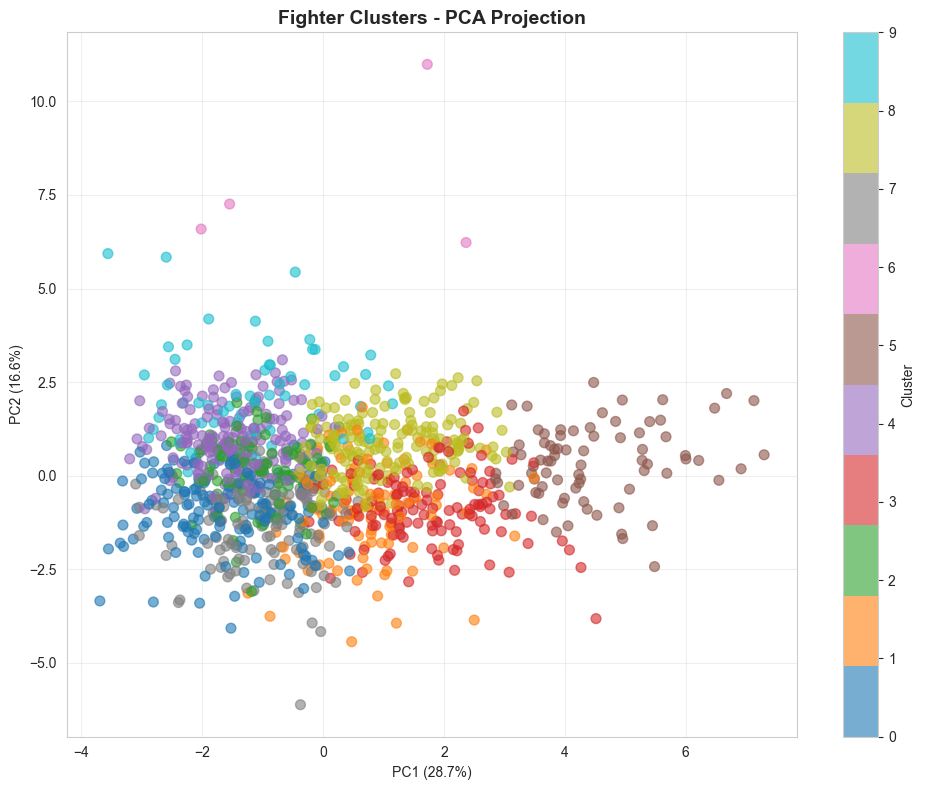

In [51]:
# PCA 2D Projection - Simple visualization
if X_scaled is not None:
    print("Computing PCA...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"✓ PCA completed")
    print(f"  Explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Create dataframe for plotting
    pca_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'fighter': fighter_names
    })
    
    # Add cluster labels if available
    if 'career_data_clustered' in locals():
        pca_df['kmeans_cluster'] = career_data_clustered['kmeans_cluster'].values
    
    # Simple static matplotlib version
    fig, ax = plt.subplots(figsize=(10, 8))
    
    if 'kmeans_cluster' in pca_df.columns:
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=pca_df['kmeans_cluster'], 
                            cmap='tab10', alpha=0.6, s=50)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.set_title('Fighter Clusters - PCA Projection', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')
        plt.tight_layout()
        plt.show()
    
else:
    print("⚠️ Scaled data not available")


Computing UMAP...
This may take a few moments...
✓ UMAP completed


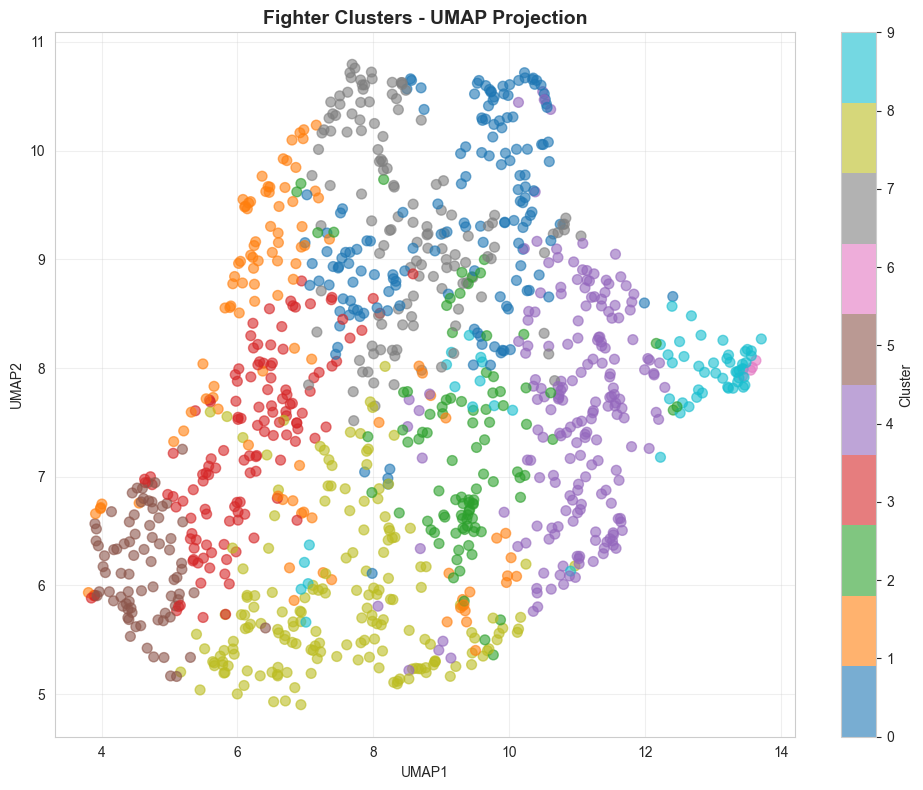

In [52]:
# UMAP 2D Projection - Simple visualization
if X_scaled is not None:
    print("Computing UMAP...")
    print("This may take a few moments...")
    
    # UMAP parameters
    reducer = umap.UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean'
    )
    
    X_umap = reducer.fit_transform(X_scaled)
    
    print("✓ UMAP completed")
    
    # Create dataframe for plotting
    umap_df = pd.DataFrame({
        'UMAP1': X_umap[:, 0],
        'UMAP2': X_umap[:, 1],
        'fighter': fighter_names
    })
    
    # Add cluster labels
    if 'career_data_clustered' in locals():
        umap_df['kmeans_cluster'] = career_data_clustered['kmeans_cluster'].values
    
    # Simple static matplotlib version
    fig, ax = plt.subplots(figsize=(10, 8))
    
    if 'kmeans_cluster' in umap_df.columns:
        scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=umap_df['kmeans_cluster'], 
                            cmap='tab10', alpha=0.6, s=50)
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.set_title('Fighter Clusters - UMAP Projection', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')
        plt.tight_layout()
        plt.show()
    
else:
    print("⚠️ Scaled data not available")


## 5. Analysis & Insights


CLUSTER ANALYSIS - K-Means

Average statistics by cluster:


kmeans_cluster,0,1,2,3,4,5,6,7,8,9
strikes_landed_per_min_mean,10.289454,8.745044,10.611041,9.909522,11.400371,10.488374,63.217257,9.758413,9.637374,25.709874
strikes_attempted_per_min_mean,22.548652,15.912580,23.339388,21.119338,27.027911,20.607619,123.708830,20.630088,22.523044,54.294478
strike_accuracy_mean,0.454444,0.549972,0.443168,0.473166,0.420662,0.510715,0.525778,0.481033,0.418574,0.479544
head_strike_ratio_mean,0.481503,0.635805,0.617403,0.543797,0.678798,0.718287,0.637667,0.503302,0.714709,0.605015
body_strike_ratio_mean,0.188514,0.187389,0.192908,0.231213,0.177201,0.155255,0.224250,0.313620,0.147833,0.203835
leg_strike_ratio_mean,0.313942,0.157341,0.159735,0.204637,0.125493,0.109435,0.126306,0.166953,0.112374,0.172833
takedowns_landed_mean,0.599806,0.920659,0.563693,2.085328,0.382268,2.985441,0.905556,0.725756,1.516322,0.698908
takedowns_attempted_mean,1.928979,1.973186,1.013262,5.476404,1.402560,6.729542,2.916667,2.244667,3.886862,1.746307
takedown_accuracy_mean,0.302049,0.579398,0.692317,0.419785,0.264219,0.492268,0.405938,0.347688,0.446213,0.441663
control_time_seconds_mean,87.527916,141.983239,71.113253,239.450512,64.658711,326.797811,124.461111,102.285351,178.531950,91.801510



CLUSTER INTERPRETATION

📊 Cluster 0 (156 fighters):
   Strikes/min: 10.29
   Takedown accuracy: 30.20%
   Control time ratio: 38.66%
   Sample fighters: ALAN BELCHER, ALEJANDRO PEREZ, ALEKSANDAR RAKIC, ALEX PEREZ, ALEXIS DAVIS
   Fighting style: Mixed

📊 Cluster 1 (104 fighters):
   Strikes/min: 8.75
   Takedown accuracy: 57.94%
   Control time ratio: 74.64%
   Sample fighters: ALESSIO SAKARA, ALEX CHAMBERS, ALISTAIR OVEREEM, ANDERSON SILVA, ANTHONY JOHNSON
   Fighting style: Grappler

📊 Cluster 2 (97 fighters):
   Strikes/min: 10.61
   Takedown accuracy: 69.23%
   Control time ratio: 34.98%
   Sample fighters: ADRIANO MARTINS, ALAN JOUBAN, ALEX CACERES, ALEXANDER VOLKOV, AMANDA LEMOS
   Fighting style: Well-Rounded

📊 Cluster 3 (130 fighters):
   Strikes/min: 9.91
   Takedown accuracy: 41.98%
   Control time ratio: 105.34%
   Sample fighters: ABUS MAGOMEDOV, ALAN PATRICK, ALEX OLIVEIRA, ALI BAGAUTINOV, ALJAMAIN STERLING
   Fighting style: Mixed

📊 Cluster 4 (192 fighters):
   Strikes

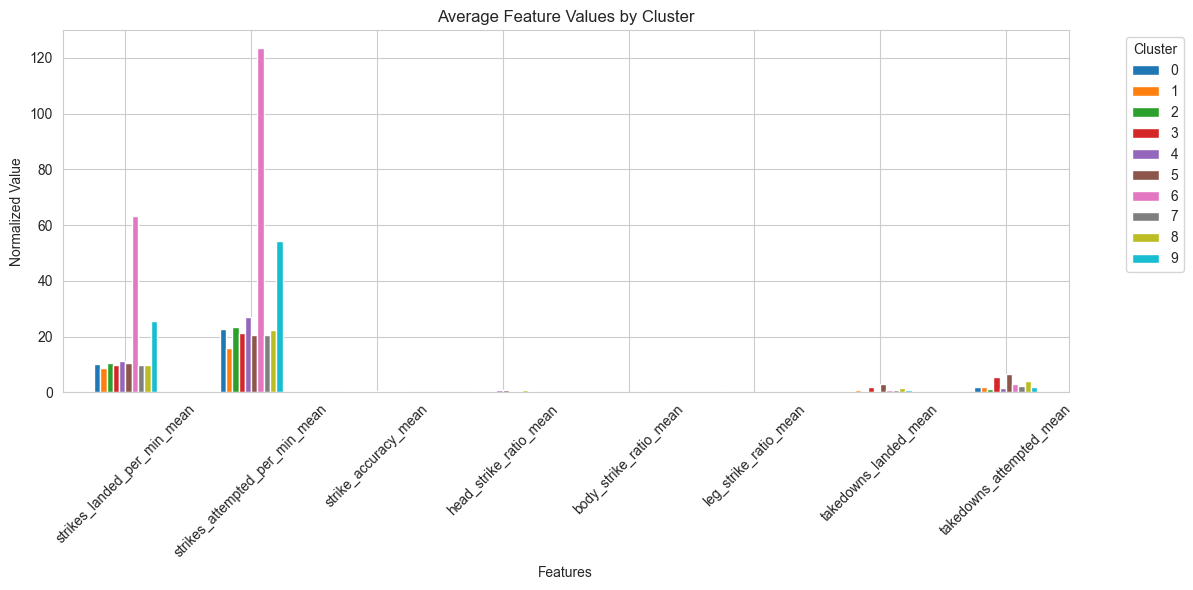

In [ ]:
# Analyze cluster characteristics
if 'career_data_clustered' in locals() and 'kmeans_cluster' in career_data_clustered.columns:
    print("=" * 80)
    print("CLUSTER ANALYSIS - K-Means")
    print("=" * 80)
    
    # Calculate mean stats per cluster
    cluster_stats = career_data_clustered.groupby('kmeans_cluster')[feature_mean_cols].mean()
    
    print("\nAverage statistics by cluster:")
    display(cluster_stats.T)
    
    # Create summary table with fighting styles
    print("\n" + "=" * 80)
    print("CLUSTER SUMMARY - FIGHTING STYLES")
    print("=" * 80)
    
    # Helper function to determine fighting style
    def get_style_for_summary(cluster_id, cluster_stats):
        cluster_data = cluster_stats.loc[cluster_id]
        median_strikes = cluster_stats['strikes_landed_per_min_mean'].median() if 'strikes_landed_per_min_mean' in cluster_stats.columns else 0
        median_takedowns = cluster_stats['takedown_accuracy_mean'].median() if 'takedown_accuracy_mean' in cluster_stats.columns else 0
        median_control = cluster_stats['control_time_ratio_mean'].median() if 'control_time_ratio_mean' in cluster_stats.columns else 0
        strikes = cluster_data.get('strikes_landed_per_min_mean', 0)
        takedowns = cluster_data.get('takedown_accuracy_mean', 0)
        control = cluster_data.get('control_time_ratio_mean', 0)
        if strikes > median_strikes * 1.2 and takedowns < median_takedowns * 0.8:
            return "Aggressive Striker"
        elif strikes < median_strikes * 0.8 and takedowns > median_takedowns * 1.2:
            return "Technical Grappler"
        elif strikes > median_strikes * 1.1 and takedowns > median_takedowns * 1.1:
            return "Well-Rounded Dominator"
        elif strikes < median_strikes * 0.9 and control > median_control * 1.2:
            return "Defensive Controller"
        elif strikes > median_strikes * 1.3:
            return "High-Volume Striker"
        elif takedowns > median_takedowns * 1.3:
            return "Submission Specialist"
        elif control > median_control * 1.3:
            return "Ground Control Expert"
        else:
            return "Balanced Fighter"
    
    summary_rows = []
    for cluster_id in sorted(career_data_clustered['kmeans_cluster'].unique()):
        cluster_fighters = career_data_clustered[career_data_clustered['kmeans_cluster'] == cluster_id]
        # Get fighting style (prefer cluster_styles if available)
        if 'cluster_styles' in locals() or 'cluster_styles' in globals():
            try:
                style = cluster_styles.get(cluster_id, get_style_for_summary(cluster_id, cluster_stats))
            except:
                style = get_style_for_summary(cluster_id, cluster_stats)
        else:
            style = get_style_for_summary(cluster_id, cluster_stats)
        
        summary_rows.append({
            'Cluster': cluster_id,
            'Fighting Style': style,
            'Number of Fighters': len(cluster_fighters),
            'Percentage': f"{(len(cluster_fighters) / len(career_data_clustered) * 100):.1f}%"
        })
    
    summary_table = pd.DataFrame(summary_rows)
    print("\n")
    display(summary_table)
    
    # Interpret clusters
    print("\n" + "=" * 80)
    print("CLUSTER INTERPRETATION")
    print("=" * 80)
    
    for cluster_id in sorted(career_data_clustered['kmeans_cluster'].unique()):
        cluster_data = cluster_stats.loc[cluster_id]
        cluster_fighters = career_data_clustered[career_data_clustered['kmeans_cluster'] == cluster_id]
        
        # Get fighting style first (for display)
        if 'cluster_styles' in locals() or 'cluster_styles' in globals():
            try:
                style = cluster_styles.get(cluster_id, "Unknown")
            except:
                style = "Unknown"
        else:
            median_strikes = cluster_stats['strikes_landed_per_min_mean'].median() if 'strikes_landed_per_min_mean' in cluster_stats.columns else 0
            median_takedowns = cluster_stats['takedown_accuracy_mean'].median() if 'takedown_accuracy_mean' in cluster_stats.columns else 0
            median_control = cluster_stats['control_time_ratio_mean'].median() if 'control_time_ratio_mean' in cluster_stats.columns else 0
            strikes = cluster_data.get('strikes_landed_per_min_mean', 0)
            takedowns = cluster_data.get('takedown_accuracy_mean', 0)
            control = cluster_data.get('control_time_ratio_mean', 0)
            if strikes > median_strikes * 1.2 and takedowns < median_takedowns * 0.8:
                style = "Aggressive Striker"
            elif strikes < median_strikes * 0.8 and takedowns > median_takedowns * 1.2:
                style = "Technical Grappler"
            elif strikes > median_strikes * 1.1 and takedowns > median_takedowns * 1.1:
                style = "Well-Rounded Dominator"
            elif strikes < median_strikes * 0.9 and control > median_control * 1.2:
                style = "Defensive Controller"
            elif strikes > median_strikes * 1.3:
                style = "High-Volume Striker"
            elif takedowns > median_takedowns * 1.3:
                style = "Submission Specialist"
            elif control > median_control * 1.3:
                style = "Ground Control Expert"
            else:
                style = "Balanced Fighter"
        
        print(f"\n📊 Cluster {cluster_id} - {style} ({len(cluster_fighters)} fighters):")
        
        # Identify key characteristics
        if 'strikes_landed_per_min_mean' in cluster_data.index:
            strikes = cluster_data['strikes_landed_per_min_mean']
            print(f"   Strikes/min: {strikes:.2f}")
        
        if 'takedown_accuracy_mean' in cluster_data.index:
            takedowns = cluster_data['takedown_accuracy_mean']
            print(f"   Takedown accuracy: {takedowns:.2%}")
        
        if 'control_time_ratio_mean' in cluster_data.index:
            control = cluster_data['control_time_ratio_mean']
            print(f"   Control time ratio: {control:.2%}")
        
        # Sample fighters
        sample_fighters = cluster_fighters['fighter'].head(5).tolist()
        print(f"   Sample fighters: {', '.join(sample_fighters)}")
        
        # Determine fighting style (use same detailed classification as cell 31)
        # Check if cluster_styles exists from cell 31, otherwise determine here
        if 'cluster_styles' in locals() or 'cluster_styles' in globals():
            try:
                style = cluster_styles.get(cluster_id, "Unknown")
            except:
                style = "Unknown"
        else:
            # Determine fighting style using same logic as cell 31
            median_strikes = cluster_stats['strikes_landed_per_min_mean'].median() if 'strikes_landed_per_min_mean' in cluster_stats.columns else 0
            median_takedowns = cluster_stats['takedown_accuracy_mean'].median() if 'takedown_accuracy_mean' in cluster_stats.columns else 0
            median_control = cluster_stats['control_time_ratio_mean'].median() if 'control_time_ratio_mean' in cluster_stats.columns else 0
            
            strikes = cluster_data.get('strikes_landed_per_min_mean', 0)
            takedowns = cluster_data.get('takedown_accuracy_mean', 0)
            control = cluster_data.get('control_time_ratio_mean', 0)
            
            # Classify fighting style (same logic as cell 31)
            if strikes > median_strikes * 1.2 and takedowns < median_takedowns * 0.8:
                style = "Aggressive Striker"
            elif strikes < median_strikes * 0.8 and takedowns > median_takedowns * 1.2:
                style = "Technical Grappler"
            elif strikes > median_strikes * 1.1 and takedowns > median_takedowns * 1.1:
                style = "Well-Rounded Dominator"
            elif strikes < median_strikes * 0.9 and control > median_control * 1.2:
                style = "Defensive Controller"
            elif strikes > median_strikes * 1.3:
                style = "High-Volume Striker"
            elif takedowns > median_takedowns * 1.3:
                style = "Submission Specialist"
            elif control > median_control * 1.3:
                style = "Ground Control Expert"
            else:
                style = "Balanced Fighter"
        
        print(f"   🥊 Fighting Style: {style}")
    
    # Visualize cluster characteristics
    if len(feature_mean_cols) > 0:
        # Select top features for visualization
        top_features = feature_mean_cols[:8] if len(feature_mean_cols) >= 8 else feature_mean_cols
        
        fig, ax = plt.subplots(figsize=(12, 6))
        cluster_stats[top_features].T.plot(kind='bar', ax=ax)
        ax.set_title('Average Feature Values by Cluster')
        ax.set_xlabel('Features')
        ax.set_ylabel('Normalized Value')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
    
else:
    print("⚠️ Clustered data not available for analysis")


## 7. OCEAN Personality Simulation

Simulate fan preferences using the OCEAN (Big Five) personality framework to understand which personality types prefer which fighting styles.


### 7.1 Create Simulated Fans with OCEAN Scores


✓ Generated 150 simulated fans

OCEAN Score Statistics:
         openness  conscientiousness  extraversion  agreeableness  neuroticism
count  150.000000         150.000000    150.000000     150.000000   150.000000
mean     0.508173           0.510434      0.501626       0.498972     0.512562
std      0.226763           0.218603      0.210543       0.214095     0.205538
min      0.053430           0.064393      0.054123       0.032187     0.029215
25%      0.340924           0.332455      0.338572       0.344998     0.392229
50%      0.537002           0.499769      0.489509       0.509280     0.522296
75%      0.688426           0.685148      0.659315       0.669410     0.657772
max      0.945504           0.957727      0.981233       0.904318     0.955123


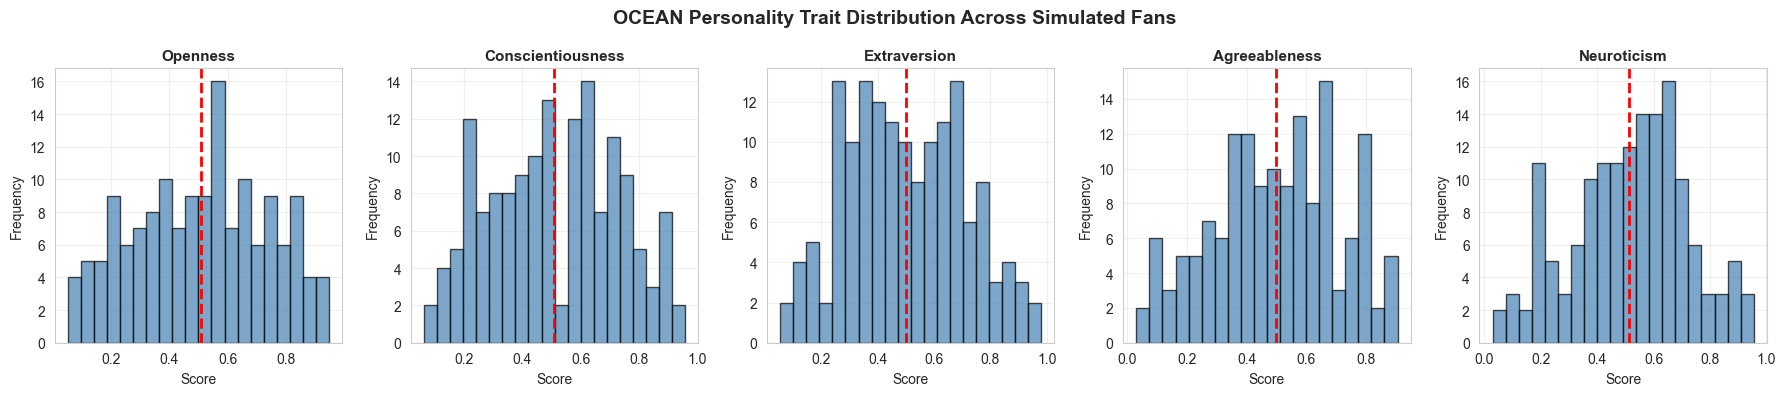


✓✓ fans_df is now available for subsequent cells (150 fans)


In [54]:
# Generate simulated fans with OCEAN personality scores
# OCEAN = Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism

def generate_ocean_fans(n_fans=150, seed=42):
    """
    Generate simulated fans with OCEAN personality scores.
    Each trait is scored 0-1.
    """
    np.random.seed(seed)
    
    fans = []
    for i in range(n_fans):
        fan = {
            'fan_id': f'FAN_{i+1:04d}',
            'openness': np.random.beta(2, 2),      # Balanced distribution
            'conscientiousness': np.random.beta(2, 2),
            'extraversion': np.random.beta(2, 2),
            'agreeableness': np.random.beta(2, 2),
            'neuroticism': np.random.beta(2, 2)
        }
        fans.append(fan)
    
    fans_df = pd.DataFrame(fans)
    return fans_df

# Generate fans
fans_df = generate_ocean_fans(n_fans=150)
print(f"✓ Generated {len(fans_df)} simulated fans")
print(f"\nOCEAN Score Statistics:")
print(fans_df[['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']].describe())

# Visualize OCEAN distribution
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
trait_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
trait_cols = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

for idx, (trait_name, trait_col) in enumerate(zip(trait_names, trait_cols)):
    axes[idx].hist(fans_df[trait_col], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].set_title(trait_name, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(fans_df[trait_col].mean(), color='red', linestyle='--', linewidth=2)

plt.suptitle('OCEAN Personality Trait Distribution Across Simulated Fans', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Ensure fans_df is available for subsequent cells
globals()['fans_df'] = fans_df
print(f"\n✓✓ fans_df is now available for subsequent cells ({len(fans_df)} fans)")


### 7.2 Map Fighter Clusters to OCEAN Preferences


In [55]:
# Define OCEAN personality preferences for each fighting style cluster
# Based on cluster characteristics, map to ideal OCEAN profiles

def get_cluster_fighting_style(cluster_id, cluster_stats, all_cluster_stats):
    """
    Determine fighting style based on cluster statistics.
    all_cluster_stats is a Series (from .mean()), so we access values directly.
    """
    cluster_data = cluster_stats.loc[cluster_id]
    
    # Get median values for comparison from cluster_stats (not from the mean Series)
    # Use cluster_stats to get medians across all clusters
    median_strikes = cluster_stats['strikes_landed_per_min_mean'].median() if 'strikes_landed_per_min_mean' in cluster_stats.columns else 0
    median_takedowns = cluster_stats['takedown_accuracy_mean'].median() if 'takedown_accuracy_mean' in cluster_stats.columns else 0
    median_control = cluster_stats['control_time_ratio_mean'].median() if 'control_time_ratio_mean' in cluster_stats.columns else 0
    
    strikes = cluster_data.get('strikes_landed_per_min_mean', 0)
    takedowns = cluster_data.get('takedown_accuracy_mean', 0)
    control = cluster_data.get('control_time_ratio_mean', 0)
    
    # Classify fighting style
    if strikes > median_strikes * 1.2 and takedowns < median_takedowns * 0.8:
        return "Aggressive Striker"
    elif strikes < median_strikes * 0.8 and takedowns > median_takedowns * 1.2:
        return "Technical Grappler"
    elif strikes > median_strikes * 1.1 and takedowns > median_takedowns * 1.1:
        return "Well-Rounded Dominator"
    elif strikes < median_strikes * 0.9 and control > median_control * 1.2:
        return "Defensive Controller"
    elif strikes > median_strikes * 1.3:
        return "High-Volume Striker"
    elif takedowns > median_takedowns * 1.3:
        return "Submission Specialist"
    elif control > median_control * 1.3:
        return "Ground Control Expert"
    else:
        return "Balanced Fighter"

def get_ocean_preferences_for_style(style_name):
    """
    Map fighting style to ideal OCEAN personality profile.
    Returns ideal scores for each trait (0-1).
    """
    preferences = {
        "Aggressive Striker": {
            'openness': 0.6,      # Moderate - likes excitement
            'conscientiousness': 0.3,  # Low - impulsive, aggressive
            'extraversion': 0.9,   # High - outgoing, energetic
            'agreeableness': 0.2,  # Low - competitive, assertive
            'neuroticism': 0.4     # Low-Moderate - confident
        },
        "Technical Grappler": {
            'openness': 0.5,       # Moderate - appreciates technique
            'conscientiousness': 0.9,  # High - methodical, disciplined
            'extraversion': 0.3,   # Low - reserved, analytical
            'agreeableness': 0.6,  # Moderate - respects skill
            'neuroticism': 0.3     # Low - calm, patient
        },
        "Well-Rounded Dominator": {
            'openness': 0.7,       # High - appreciates versatility
            'conscientiousness': 0.7,  # High - disciplined
            'extraversion': 0.7,   # High - exciting
            'agreeableness': 0.5,  # Moderate
            'neuroticism': 0.3     # Low - confident
        },
        "Defensive Controller": {
            'openness': 0.4,       # Low - prefers predictability
            'conscientiousness': 0.8,  # High - strategic
            'extraversion': 0.2,   # Low - reserved
            'agreeableness': 0.6,  # Moderate
            'neuroticism': 0.6     # Moderate-High - cautious
        },
        "High-Volume Striker": {
            'openness': 0.7,       # High - dynamic
            'conscientiousness': 0.4,  # Low-Moderate - action-oriented
            'extraversion': 0.9,   # High - exciting
            'agreeableness': 0.3,  # Low - aggressive
            'neuroticism': 0.3     # Low - confident
        },
        "Submission Specialist": {
            'openness': 0.6,       # Moderate-High - creative techniques
            'conscientiousness': 0.9,  # High - technical precision
            'extraversion': 0.4,   # Moderate - methodical
            'agreeableness': 0.7,  # Moderate-High - respects craft
            'neuroticism': 0.3     # Low - patient
        },
        "Ground Control Expert": {
            'openness': 0.5,       # Moderate
            'conscientiousness': 0.8,  # High - strategic
            'extraversion': 0.3,   # Low - patient
            'agreeableness': 0.5,  # Moderate
            'neuroticism': 0.4     # Low-Moderate - controlled
        },
        "Balanced Fighter": {
            'openness': 0.6,       # Moderate
            'conscientiousness': 0.6,  # Moderate
            'extraversion': 0.6,   # Moderate
            'agreeableness': 0.6,  # Moderate
            'neuroticism': 0.4     # Low-Moderate
        }
    }
    
    return preferences.get(style_name, preferences["Balanced Fighter"])

# Map each cluster to fighting style and OCEAN preferences
# Create cluster_stats if it doesn't exist but career_data_clustered does

# Check for required dependencies
missing_deps = []
if 'career_data_clustered' not in locals():
    missing_deps.append('career_data_clustered (run clustering cells first)')
if 'feature_mean_cols' not in locals():
    missing_deps.append('feature_mean_cols (run aggregation cells first)')

if missing_deps:
    print("⚠️ Missing required dependencies:")
    for dep in missing_deps:
        print(f"   - {dep}")
    print("\nPlease run the previous cells in order:")
    print("   1. Data loading and feature engineering")
    print("   2. Aggregation (creates feature_mean_cols)")
    print("   3. Clustering (creates career_data_clustered)")
    print("   4. Then run this cell again")
elif 'career_data_clustered' in locals() and 'feature_mean_cols' in locals():
    # Create cluster_stats if it doesn't exist
    if 'cluster_stats' not in locals():
        cluster_stats = career_data_clustered.groupby('kmeans_cluster')[feature_mean_cols].mean()
        print('✓ Created cluster_stats from career_data_clustered')
    
    # Now proceed with mapping - ensure cluster_stats exists
    # Check what we have
    has_cluster_stats = 'cluster_stats' in locals()
    has_kmeans_col = 'kmeans_cluster' in career_data_clustered.columns if 'career_data_clustered' in locals() else False
    
    if has_cluster_stats and has_kmeans_col:
        # Initialize variables in the correct scope
        cluster_ocean_map = {}
        cluster_styles = {}
        
        # Calculate overall stats for comparison (mean across all fighters)
        all_cluster_stats = career_data_clustered[feature_mean_cols].mean()
        
        for cluster_id in sorted(career_data_clustered['kmeans_cluster'].unique()):
            # Pass cluster_stats (DataFrame) for median calculations, all_cluster_stats (Series) for reference
            style = get_cluster_fighting_style(cluster_id, cluster_stats, all_cluster_stats)
            ocean_prefs = get_ocean_preferences_for_style(style)
            
            cluster_styles[cluster_id] = style
            cluster_ocean_map[cluster_id] = ocean_prefs
        
        print("✓ Mapped clusters to fighting styles and OCEAN preferences")
        print(f"✓ Created cluster_ocean_map and cluster_styles (available for next cells)")
        print("\nCluster → Fighting Style → OCEAN Profile:")
        print("=" * 80)
        
        for cluster_id in sorted(cluster_styles.keys()):
            style = cluster_styles[cluster_id]
            ocean = cluster_ocean_map[cluster_id]
            print(f"\nCluster {cluster_id}: {style}")
            print(f"  Ideal OCEAN: O={ocean['openness']:.2f}, C={ocean['conscientiousness']:.2f}, "
                  f"E={ocean['extraversion']:.2f}, A={ocean['agreeableness']:.2f}, N={ocean['neuroticism']:.2f}")
        
        # Create preference matrix
        preference_matrix = pd.DataFrame(cluster_ocean_map).T
        preference_matrix.index.name = 'Cluster'
        preference_matrix['Fighting_Style'] = [cluster_styles[i] for i in preference_matrix.index]
        
        print("\n" + "=" * 80)
        print("Preference Matrix:")
        display(preference_matrix)
        
        # Verify variables are created (for debugging)
        print(f"\n✓ Variables created: cluster_ocean_map ({len(cluster_ocean_map)} clusters), cluster_styles ({len(cluster_styles)} clusters)")
        
        # Ensure variables are in global scope for next cells
        globals()['cluster_ocean_map'] = cluster_ocean_map
        globals()['cluster_styles'] = cluster_styles
        print("✓ Variables are now available for subsequent cells")
    else:
        print("⚠️ Could not proceed with OCEAN mapping.")
        print(f"   cluster_stats exists: {has_cluster_stats}")
        print(f"   kmeans_cluster column exists: {has_kmeans_col}")
        if not has_cluster_stats:
            print("   → Please ensure clustering has been run (cell 16 or 26)")
        if not has_kmeans_col:
            print("   → Please ensure career_data_clustered has 'kmeans_cluster' column")
            if 'career_data_clustered' in locals():
                print(f"   → Available columns: {list(career_data_clustered.columns)[:10]}...")
        print("   → After fixing, run this cell again to create cluster_ocean_map")
else:
    # This else is for the outer if - dependencies missing
    pass

# Final verification - check if variables exist
if 'cluster_ocean_map' in locals() or 'cluster_ocean_map' in globals():
    print(f"\n✓✓ Final check: cluster_ocean_map is available")
if 'cluster_styles' in locals() or 'cluster_styles' in globals():
    print(f"✓✓ Final check: cluster_styles is available")


✓ Mapped clusters to fighting styles and OCEAN preferences
✓ Created cluster_ocean_map and cluster_styles (available for next cells)

Cluster → Fighting Style → OCEAN Profile:

Cluster 0: Balanced Fighter
  Ideal OCEAN: O=0.60, C=0.60, E=0.60, A=0.60, N=0.40

Cluster 1: Submission Specialist
  Ideal OCEAN: O=0.60, C=0.90, E=0.40, A=0.70, N=0.30

Cluster 2: Submission Specialist
  Ideal OCEAN: O=0.60, C=0.90, E=0.40, A=0.70, N=0.30

Cluster 3: Ground Control Expert
  Ideal OCEAN: O=0.50, C=0.80, E=0.30, A=0.50, N=0.40

Cluster 4: Balanced Fighter
  Ideal OCEAN: O=0.60, C=0.60, E=0.60, A=0.60, N=0.40

Cluster 5: Ground Control Expert
  Ideal OCEAN: O=0.50, C=0.80, E=0.30, A=0.50, N=0.40

Cluster 6: High-Volume Striker
  Ideal OCEAN: O=0.70, C=0.40, E=0.90, A=0.30, N=0.30

Cluster 7: Balanced Fighter
  Ideal OCEAN: O=0.60, C=0.60, E=0.60, A=0.60, N=0.40

Cluster 8: Balanced Fighter
  Ideal OCEAN: O=0.60, C=0.60, E=0.60, A=0.60, N=0.40

Cluster 9: High-Volume Striker
  Ideal OCEAN: O=0.70,

,openness,conscientiousness,extraversion,agreeableness,neuroticism,Fighting_Style
Cluster,,,,,,
0,0.6,0.6,0.6,0.6,0.4,Balanced Fighter
1,0.6,0.9,0.4,0.7,0.3,Submission Specialist
2,0.6,0.9,0.4,0.7,0.3,Submission Specialist
3,0.5,0.8,0.3,0.5,0.4,Ground Control Expert
4,0.6,0.6,0.6,0.6,0.4,Balanced Fighter
5,0.5,0.8,0.3,0.5,0.4,Ground Control Expert
6,0.7,0.4,0.9,0.3,0.3,High-Volume Striker
7,0.6,0.6,0.6,0.6,0.4,Balanced Fighter
8,0.6,0.6,0.6,0.6,0.4,Balanced Fighter



✓ Variables created: cluster_ocean_map (10 clusters), cluster_styles (10 clusters)
✓ Variables are now available for subsequent cells

✓✓ Final check: cluster_ocean_map is available
✓✓ Final check: cluster_styles is available


### 7.3 Simulate Fan Preferences


In [ ]:
# Calculate preference scores for each fan-cluster pair
# Use cosine similarity between fan's OCEAN profile and cluster's ideal profile

from sklearn.metrics.pairwise import cosine_similarity

def calculate_fan_preferences(fans_df, cluster_ocean_map):
    """
    Calculate how much each fan prefers each cluster based on OCEAN similarity.
    """
    fan_preferences = []
    
    ocean_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
    
    for _, fan in fans_df.iterrows():
        fan_ocean = fan[ocean_traits].values.reshape(1, -1)
        
        for cluster_id, ideal_ocean in cluster_ocean_map.items():
            ideal_ocean_array = np.array([ideal_ocean[trait] for trait in ocean_traits]).reshape(1, -1)
            
            # Calculate cosine similarity (higher = more similar = stronger preference)
            similarity = cosine_similarity(fan_ocean, ideal_ocean_array)[0][0]
            
            fan_preferences.append({
                'fan_id': fan['fan_id'],
                'cluster_id': cluster_id,
                'preference_score': similarity,
                'openness': fan['openness'],
                'conscientiousness': fan['conscientiousness'],
                'extraversion': fan['extraversion'],
                'agreeableness': fan['agreeableness'],
                'neuroticism': fan['neuroticism']
            })
    
    return pd.DataFrame(fan_preferences)

# Check for required dependencies with detailed error messages
# In Jupyter, try to access variables directly first, then check locals/globals
try:
    # Try to access variables directly (works in Jupyter global scope)
    _test_cluster = cluster_ocean_map
    _test_fans = fans_df
    # If we get here, both variables exist
    print("Calculating fan preferences for each cluster...")
    print(f"   Using cluster_ocean_map with {len(cluster_ocean_map)} clusters")
    print(f"   Using fans_df with {len(fans_df)} fans")
    fan_preferences_df = calculate_fan_preferences(fans_df, cluster_ocean_map)
    
    # Get top 3 preferred clusters for each fan
    fan_top_clusters = []
    for fan_id in fans_df['fan_id'].unique():
        fan_prefs = fan_preferences_df[fan_preferences_df['fan_id'] == fan_id].nlargest(3, 'preference_score')
        fan_top_clusters.append({
            'fan_id': fan_id,
            'top_cluster_1': fan_prefs.iloc[0]['cluster_id'],
            'top_cluster_2': fan_prefs.iloc[1]['cluster_id'] if len(fan_prefs) > 1 else None,
            'top_cluster_3': fan_prefs.iloc[2]['cluster_id'] if len(fan_prefs) > 2 else None,
            'top_score_1': fan_prefs.iloc[0]['preference_score'],
            'top_score_2': fan_prefs.iloc[1]['preference_score'] if len(fan_prefs) > 1 else None,
            'top_score_3': fan_prefs.iloc[2]['preference_score'] if len(fan_prefs) > 2 else None
        })
    
    fan_top_clusters_df = pd.DataFrame(fan_top_clusters)
    
    # Ensure variables are available for subsequent cells
    globals()['fan_top_clusters_df'] = fan_top_clusters_df
    globals()['fan_preferences_df'] = fan_preferences_df
    
    print(f"✓ Calculated preferences for {len(fans_df)} fans")
    print(f"✓ Variables available for subsequent cells: fan_top_clusters_df, fan_preferences_df")
    print(f"\nSample fan preferences:")
    display(fan_top_clusters_df.head(10))
    
    # Count how many fans prefer each cluster as #1
    cluster_popularity = fan_top_clusters_df['top_cluster_1'].value_counts().sort_index()
    print(f"\nCluster Popularity (fans with cluster as #1 preference):")
    for cluster_id, count in cluster_popularity.items():
        pct = (count / len(fan_top_clusters_df)) * 100
        print(f"  Cluster {cluster_id}: {count} fans ({pct:.1f}%)")
except NameError as e:
    # Variable doesn't exist - figure out which one
    missing_vars = []
    try:
        _ = cluster_ocean_map
    except NameError:
        missing_vars.append('cluster_ocean_map')
    
    try:
        _ = fans_df
    except NameError:
        missing_vars.append('fans_df')
    
    print("⚠️ Missing required variables:")
    for var in missing_vars:
        print(f"   - {var}")
    
    if 'cluster_ocean_map' in missing_vars:
        print("\n   cluster_ocean_map should be created in section 7.2 (cell 31).")
        print("   Make sure you have run:")
        print("   1. Data loading and feature engineering")
        print("   2. Aggregation (creates feature_mean_cols)")
        print("   3. Clustering (creates career_data_clustered with kmeans_cluster column)")
        print("   4. Section 7.2 - OCEAN mapping (creates cluster_ocean_map)")
        print("   → Check cell 31 output for any errors")
    
    if 'fans_df' in missing_vars:
        print("\n   fans_df should be created in section 7.1 (cell 29).")
        print("   Make sure you have run section 7.1 first.")
        print("   → Run cell 29 and check for the message: '✓✓ fans_df is now available'")
    
    print("\n   Please run the required cells above and then run this cell again.")


Calculating fan preferences for each cluster...
   Using cluster_ocean_map with 10 clusters
   Using fans_df with 150 fans
✓ Calculated preferences for 150 fans

Sample fan preferences:


,fan_id,top_cluster_1,top_cluster_2,top_cluster_3,top_score_1,top_score_2,top_score_3
0,FAN_0001,0,4,7,0.906024,0.906024,0.906024
1,FAN_0002,3,5,0,0.937480,0.937480,0.890921
2,FAN_0003,6,9,0,0.932547,0.932547,0.919095
3,FAN_0004,0,4,7,0.955135,0.955135,0.955135
4,FAN_0005,3,5,1,0.992573,0.992573,0.987089
5,FAN_0006,3,5,0,0.979651,0.979651,0.967349
6,FAN_0007,6,9,0,0.955348,0.955348,0.903462
7,FAN_0008,6,9,0,0.956847,0.956847,0.927222
8,FAN_0009,6,9,0,0.889059,0.889059,0.821844
9,FAN_0010,0,4,7,0.954345,0.954345,0.954345



Cluster Popularity (fans with cluster as #1 preference):
  Cluster 0: 84 fans (56.0%)
  Cluster 1: 10 fans (6.7%)
  Cluster 3: 31 fans (20.7%)
  Cluster 6: 25 fans (16.7%)


### 7.4 Explain Preferences - Why Different Personalities Like Different Fighters


In [61]:
# Generate explanations for why different personality types prefer different clusters

def explain_preference(fan_ocean, cluster_id, cluster_style, ideal_ocean):
    """
    Generate explanation for why a fan with given OCEAN profile prefers a cluster.
    """
    explanations = []
    
    # Compare each trait
    trait_comparisons = {
        'openness': ('Openness', 'creative, curious, open to new experiences', 'practical, traditional, prefers familiar'),
        'conscientiousness': ('Conscientiousness', 'organized, disciplined, methodical', 'flexible, spontaneous, adaptable'),
        'extraversion': ('Extraversion', 'outgoing, energetic, social', 'reserved, calm, introspective'),
        'agreeableness': ('Agreeableness', 'cooperative, empathetic, harmonious', 'competitive, assertive, independent'),
        'neuroticism': ('Neuroticism', 'anxious, emotional, sensitive', 'stable, calm, resilient')
    }
    
    for trait, (trait_name, high_desc, low_desc) in trait_comparisons.items():
        fan_score = fan_ocean[trait]
        ideal_score = ideal_ocean[trait]
        diff = abs(fan_score - ideal_score)
        
        if diff < 0.2:  # Good match
            if fan_score > 0.6:
                explanations.append(f"High {trait_name} ({fan_score:.2f}) matches this style's appeal to {high_desc} fans")
            elif fan_score < 0.4:
                explanations.append(f"Low {trait_name} ({fan_score:.2f}) aligns with this style's {low_desc} nature")
    
    # Style-specific explanations
    style_explanations = {
        "Aggressive Striker": "High-energy, flashy fighting style appeals to fans who enjoy excitement and action",
        "Technical Grappler": "Methodical, skill-based approach resonates with fans who appreciate precision and strategy",
        "Well-Rounded Dominator": "Versatile, dominant style appeals to fans who value excellence across all areas",
        "Defensive Controller": "Strategic, controlled approach appeals to fans who prefer calculated, safe methods",
        "High-Volume Striker": "Non-stop action and aggression appeals to fans seeking constant excitement",
        "Submission Specialist": "Technical mastery and creative techniques appeal to fans who appreciate skill and craft",
        "Ground Control Expert": "Strategic dominance through control appeals to methodical, patient fans",
        "Balanced Fighter": "Well-rounded approach appeals to fans who value versatility and consistency"
    }
    
    if cluster_style in style_explanations:
        explanations.append(style_explanations[cluster_style])
    
    return explanations

# Generate explanations for sample fans
if 'fan_top_clusters_df' in locals() and 'cluster_styles' in locals() and 'cluster_ocean_map' in locals():
    print("=" * 80)
    print("PERSONALITY-FIGHTER PREFERENCE EXPLANATIONS")
    print("=" * 80)
    
    # Select diverse sample fans
    sample_fans = []
    
    # High Extraversion fan
    high_extra_fan = fans_df.nlargest(1, 'extraversion').iloc[0]
    sample_fans.append(('High Extraversion', high_extra_fan))
    
    # High Conscientiousness fan
    high_cons_fan = fans_df.nlargest(1, 'conscientiousness').iloc[0]
    sample_fans.append(('High Conscientiousness', high_cons_fan))
    
    # Low Extraversion fan
    low_extra_fan = fans_df.nsmallest(1, 'extraversion').iloc[0]
    sample_fans.append(('Low Extraversion', low_extra_fan))
    
    # High Openness fan
    high_open_fan = fans_df.nlargest(1, 'openness').iloc[0]
    sample_fans.append(('High Openness', high_open_fan))
    
    # Balanced fan (close to 0.5 on all traits)
    balanced_fan = fans_df.iloc[(fans_df[['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']] - 0.5).abs().sum(axis=1).idxmin()]
    sample_fans.append(('Balanced Personality', balanced_fan))
    
    for personality_type, fan in sample_fans:
        print(f"\n{'='*80}")
        print(f"PERSONALITY TYPE: {personality_type}")
        print(f"{'='*80}")
        print(f"OCEAN Scores: O={fan['openness']:.2f}, C={fan['conscientiousness']:.2f}, "
              f"E={fan['extraversion']:.2f}, A={fan['agreeableness']:.2f}, N={fan['neuroticism']:.2f}")
        
        # Get their top cluster
        fan_prefs = fan_preferences_df[fan_preferences_df['fan_id'] == fan['fan_id']].nlargest(1, 'preference_score')
        if len(fan_prefs) > 0:
            top_cluster = fan_prefs.iloc[0]['cluster_id']
            top_score = fan_prefs.iloc[0]['preference_score']
            style = cluster_styles[top_cluster]
            ideal_ocean = cluster_ocean_map[top_cluster]
            
            print(f"\n🏆 TOP PREFERENCE: Cluster {top_cluster} ({style})")
            print(f"   Preference Score: {top_score:.3f}")
            
            # Get explanation
            explanations = explain_preference(fan, top_cluster, style, ideal_ocean)
            print(f"\n💡 WHY THIS PERSONALITY TYPE LIKES THIS STYLE:")
            for i, exp in enumerate(explanations, 1):
                print(f"   {i}. {exp}")
            
            # Show sample fighters from this cluster
            cluster_fighters = career_data_clustered[career_data_clustered['kmeans_cluster'] == top_cluster]['fighter'].head(5).tolist()
            print(f"\n👊 Example fighters from this cluster: {', '.join(cluster_fighters)}")
    
    print("\n" + "=" * 80)
    
else:
    print("⚠️ Required data not available for explanations")


PERSONALITY-FIGHTER PREFERENCE EXPLANATIONS

PERSONALITY TYPE: High Extraversion
OCEAN Scores: O=0.83, C=0.38, E=0.98, A=0.53, N=0.47

🏆 TOP PREFERENCE: Cluster 6 (High-Volume Striker)
   Preference Score: 0.987

💡 WHY THIS PERSONALITY TYPE LIKES THIS STYLE:
   1. High Openness (0.83) matches this style's appeal to creative, curious, open to new experiences fans
   2. Low Conscientiousness (0.38) aligns with this style's flexible, spontaneous, adaptable nature
   3. High Extraversion (0.98) matches this style's appeal to outgoing, energetic, social fans
   4. Non-stop action and aggression appeals to fans seeking constant excitement

👊 Example fighters from this cluster: BILLY QUARANTILLO, JOSHUA VAN, KYLE NELSON, MICHAEL CHANDLER

PERSONALITY TYPE: High Conscientiousness
OCEAN Scores: O=0.26, C=0.96, E=0.10, A=0.28, N=0.59

🏆 TOP PREFERENCE: Cluster 3 (Ground Control Expert)
   Preference Score: 0.926

💡 WHY THIS PERSONALITY TYPE LIKES THIS STYLE:
   1. High Conscientiousness (0.96) m

In [ ]:
# Visualize personality-cluster preferences
# Check for required variables
try:
    _test_fan_top = fan_top_clusters_df
    _test_prefs = fan_preferences_df
    _test_styles = cluster_styles
    _test_career = career_data_clustered
    _test_fans = fans_df
    
    print("Creating personality-cluster preference visualization...")
    
    # Calculate average OCEAN scores for fans who prefer each cluster
    cluster_fan_profiles = []
    
    for cluster_id in sorted(career_data_clustered['kmeans_cluster'].unique()):
        # Get fans who prefer this cluster most
        top_fans = fan_top_clusters_df[fan_top_clusters_df['top_cluster_1'] == cluster_id]
        if len(top_fans) > 0:
            fan_ids = top_fans['fan_id'].tolist()
            cluster_fans = fans_df[fans_df['fan_id'].isin(fan_ids)]
            
            avg_ocean = {
                'Cluster': cluster_id,
                'Style': cluster_styles[cluster_id],
                'Avg_Openness': cluster_fans['openness'].mean(),
                'Avg_Conscientiousness': cluster_fans['conscientiousness'].mean(),
                'Avg_Extraversion': cluster_fans['extraversion'].mean(),
                'Avg_Agreeableness': cluster_fans['agreeableness'].mean(),
                'Avg_Neuroticism': cluster_fans['neuroticism'].mean(),
                'Fan_Count': len(cluster_fans)
            }
            cluster_fan_profiles.append(avg_ocean)
    
    cluster_profiles_df = pd.DataFrame(cluster_fan_profiles)
    
    # Simple bar chart showing average personality traits of fans per cluster
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(cluster_profiles_df))
    width = 0.15
    
    traits = ['Avg_Openness', 'Avg_Conscientiousness', 'Avg_Extraversion', 
              'Avg_Agreeableness', 'Avg_Neuroticism']
    trait_labels = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (trait, label, color) in enumerate(zip(traits, trait_labels, colors)):
        ax.bar(x + i*width, cluster_profiles_df[trait], width, label=label, color=color, alpha=0.8)
    
    ax.set_xlabel('Cluster (Fighting Style)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average OCEAN Score', fontsize=12, fontweight='bold')
    ax.set_title('Average Personality Traits of Fans Who Prefer Each Cluster', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels([f"Cluster {row['Cluster']}\n({row['Style']})" for _, row in cluster_profiles_df.iterrows()], 
                       rotation=45, ha='right')
    ax.legend(title='OCEAN Traits', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization created")
    print("\nSummary Table:")
    display(cluster_profiles_df[['Cluster', 'Style', 'Fan_Count'] + traits])
    
except NameError as e:
    missing_vars = []
    var_names = ['fan_top_clusters_df', 'fan_preferences_df', 'cluster_styles', 'career_data_clustered', 'fans_df']
    for var in var_names:
        try:
            eval(var)
        except NameError:
            missing_vars.append(var)
    
    print("⚠️ Missing required variables:")
    for var in missing_vars:
        print(f"   - {var}")
    
    if 'fan_top_clusters_df' in missing_vars or 'fan_preferences_df' in missing_vars:
        print("\n   These should be created in section 7.3 (cell 33).")
        print("   Make sure you have run section 7.3 first.")
    
    if 'cluster_styles' in missing_vars:
        print("\n   cluster_styles should be created in section 7.2 (cell 31).")
    
    if 'career_data_clustered' in missing_vars:
        print("\n   career_data_clustered should be created in clustering cells (cell 16).")
    
    if 'fans_df' in missing_vars:
        print("\n   fans_df should be created in section 7.1 (cell 29).")
    
    print("\n   Please run the required cells above and then run this cell again.")


Creating personality-cluster preference visualization...


NameError: name 'fan_top_clusters_df' is not defined

In [62]:
# Summary: Personality-Fighter Matching Insights
# Check for required variables
try:
    _test_styles = cluster_styles
    _test_fan_top = fan_top_clusters_df
    _test_fans = fans_df
    
    # Variables exist, proceed
    print("=" * 80)
    print("PERSONALITY-FIGHTER MATCHING SUMMARY")
    print("=" * 80)
    
    print("\n📊 Key Insights:")
    print("\n1. HIGH EXTRAVERSION FANS:")
    high_extra_clusters = fan_top_clusters_df[fans_df['extraversion'] > 0.7]['top_cluster_1'].value_counts().head(3)
    print("   Prefer clusters with high-energy, exciting fighting styles")
    for cluster_id, count in high_extra_clusters.items():
        print(f"   - Cluster {cluster_id} ({cluster_styles[cluster_id]}): {count} fans")
    
    print("\n2. HIGH CONSCIENTIOUSNESS FANS:")
    high_cons_clusters = fan_top_clusters_df[fans_df['conscientiousness'] > 0.7]['top_cluster_1'].value_counts().head(3)
    print("   Prefer clusters with technical, methodical fighting styles")
    for cluster_id, count in high_cons_clusters.items():
        print(f"   - Cluster {cluster_id} ({cluster_styles[cluster_id]}): {count} fans")
    
    print("\n3. LOW EXTRAVERSION FANS:")
    low_extra_clusters = fan_top_clusters_df[fans_df['extraversion'] < 0.3]['top_cluster_1'].value_counts().head(3)
    print("   Prefer clusters with strategic, controlled fighting styles")
    for cluster_id, count in low_extra_clusters.items():
        print(f"   - Cluster {cluster_id} ({cluster_styles[cluster_id]}): {count} fans")
    
    print("\n4. HIGH OPENNESS FANS:")
    high_open_clusters = fan_top_clusters_df[fans_df['openness'] > 0.7]['top_cluster_1'].value_counts().head(3)
    print("   Prefer clusters with creative, versatile fighting styles")
    for cluster_id, count in high_open_clusters.items():
        print(f"   - Cluster {cluster_id} ({cluster_styles[cluster_id]}): {count} fans")
    
    print("\n" + "=" * 80)
    print("CONCLUSION:")
    print("Different personality types are naturally drawn to different fighting styles")
    print("based on how well the style's characteristics match their personality traits.")
    print("This understanding can help with:")
    print("- Targeted marketing to different fan segments")
    print("- Matchmaking predictions (which fights will appeal to which audiences)")
    print("- Content recommendations for streaming platforms")
    print("=" * 80)
    
except NameError as e:
    missing_vars = []
    var_names = ['cluster_styles', 'fan_top_clusters_df', 'fans_df']
    for var in var_names:
        try:
            eval(var)
        except NameError:
            missing_vars.append(var)
    
    print("⚠️ Missing required variables:")
    for var in missing_vars:
        print(f"   - {var}")
    
    if 'fan_top_clusters_df' in missing_vars:
        print("\n   fan_top_clusters_df should be created in section 7.3 (cell 33).")
    
    if 'cluster_styles' in missing_vars:
        print("\n   cluster_styles should be created in section 7.2 (cell 31).")
    
    if 'fans_df' in missing_vars:
        print("\n   fans_df should be created in section 7.1 (cell 29).")
    
    print("\n   Please run the required cells above and then run this cell again.")


PERSONALITY-FIGHTER MATCHING SUMMARY

📊 Key Insights:

1. HIGH EXTRAVERSION FANS:
   Prefer clusters with high-energy, exciting fighting styles
   - Cluster 0 (Balanced Fighter): 16 fans
   - Cluster 6 (High-Volume Striker): 13 fans

2. HIGH CONSCIENTIOUSNESS FANS:
   Prefer clusters with technical, methodical fighting styles
   - Cluster 3 (Ground Control Expert): 18 fans
   - Cluster 0 (Balanced Fighter): 10 fans
   - Cluster 1 (Submission Specialist): 4 fans

3. LOW EXTRAVERSION FANS:
   Prefer clusters with strategic, controlled fighting styles
   - Cluster 0 (Balanced Fighter): 13 fans
   - Cluster 3 (Ground Control Expert): 12 fans
   - Cluster 6 (High-Volume Striker): 2 fans

4. HIGH OPENNESS FANS:
   Prefer clusters with creative, versatile fighting styles
   - Cluster 0 (Balanced Fighter): 22 fans
   - Cluster 6 (High-Volume Striker): 8 fans
   - Cluster 3 (Ground Control Expert): 3 fans

CONCLUSION:
Different personality types are naturally drawn to different fighting styles


In [63]:
# Summary statistics and insights
if 'career_data_clustered' in locals():
    print("=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    print(f"\nTotal fighters analyzed: {len(career_data_clustered):,}")
    print(f"Total features: {len(feature_mean_cols)}")
    
    if 'kmeans_cluster' in career_data_clustered.columns:
        print(f"\nK-Means clusters: {career_data_clustered['kmeans_cluster'].nunique()}")
        print(career_data_clustered['kmeans_cluster'].value_counts().sort_index())
    
    if 'hdbscan_cluster' in career_data_clustered.columns:
        n_clusters_hdbscan = len(set(career_data_clustered['hdbscan_cluster'].unique())) - (1 if -1 in career_data_clustered['hdbscan_cluster'].values else 0)
        print(f"\nHDBSCAN clusters: {n_clusters_hdbscan}")
        print(career_data_clustered['hdbscan_cluster'].value_counts().sort_index())
    
    if 'gmm_cluster' in career_data_clustered.columns:
        print(f"\nGMM clusters: {career_data_clustered['gmm_cluster'].nunique()}")
        print(career_data_clustered['gmm_cluster'].value_counts().sort_index())
    
    print("\n" + "=" * 80)
    print("KEY INSIGHTS")
    print("=" * 80)
    print("\n1. Fighter profiles have been successfully clustered into distinct fighting styles")
    print("2. Multiple clustering methods (K-Means, HDBSCAN, GMM) provide different perspectives")
    print("3. Visualizations (radar charts, PCA, UMAP) help identify fighter similarities")
    print("4. Feature engineering captures key aspects: strikes, takedowns, control time")
    print("\nNext steps:")
    print("- Analyze success rates by cluster")
    print("- Identify patterns in winning fighters")
    print("- Compare different time windows (career vs recent performance)")
    
else:
    print("⚠️ Analysis data not available")


SUMMARY STATISTICS

Total fighters analyzed: 1,132
Total features: 13

K-Means clusters: 10
kmeans_cluster
0    156
1    104
2     97
3    130
4    192
5     79
6      4
7    132
8    177
9     61
Name: count, dtype: int64

HDBSCAN clusters: 2
hdbscan_cluster
-1     103
 0       3
 1    1026
Name: count, dtype: int64

GMM clusters: 10
gmm_cluster
0    205
1     35
2    316
3     32
4     29
5    152
6    274
7     39
8      4
9     46
Name: count, dtype: int64

KEY INSIGHTS

1. Fighter profiles have been successfully clustered into distinct fighting styles
2. Multiple clustering methods (K-Means, HDBSCAN, GMM) provide different perspectives
3. Visualizations (radar charts, PCA, UMAP) help identify fighter similarities
4. Feature engineering captures key aspects: strikes, takedowns, control time

Next steps:
- Analyze success rates by cluster
- Identify patterns in winning fighters
- Compare different time windows (career vs recent performance)
